# TF-IDF + Logistic Regression Baseline

Train and evaluate a baseline toxic comment classifier.

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = Path("../../data")
MODEL_DIR = DATA_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

## 2. Load Data

In [2]:
print("Loading dataset...")
df = pd.read_csv(DATA_DIR / "train_dataset.csv")
print(f"Total samples: {len(df)}")
print(f"Toxicity rate: {df['y'].mean():.2%}")

Loading dataset...
Total samples: 470322
Toxicity rate: 19.86%


## 3. Train/Test Split

In [3]:
X = df['text'].values
y = df['y'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 376257, Test: 94065


## 4. TF-IDF Vectorization

In [4]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print(f"Features: {X_train_tfidf.shape}")

Features: (376257, 10000)


## 5. Train Model

In [5]:
model = LogisticRegression(C=1.0, max_iter=1000, random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
model.fit(X_train_tfidf, y_train)
print("Training complete!")

/Users/ar.babkin/Desktop/Visual_Studio_IDE/GenAI-Safety-Fliter/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Training complete!


## 6. Evaluate

              precision    recall  f1-score   support

        Safe       0.92      0.98      0.95     75381
       Toxic       0.91      0.64      0.75     18684

    accuracy                           0.91     94065
   macro avg       0.91      0.81      0.85     94065
weighted avg       0.91      0.91      0.91     94065



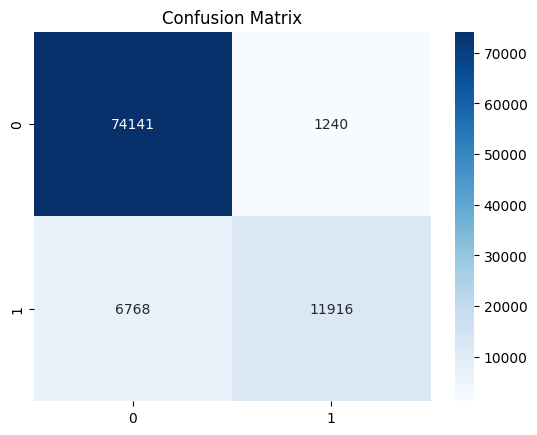

In [6]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, target_names=['Safe', 'Toxic']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 7. Save Model

In [7]:
with open(MODEL_DIR / "tfidf_vectorizer.pkl", 'wb') as f:
    pickle.dump(vectorizer, f)

with open(MODEL_DIR / "logreg_model.pkl", 'wb') as f:
    pickle.dump(model, f)

with open(MODEL_DIR / "test_data.pkl", 'wb') as f:
    pickle.dump({'X_test': X_test, 'y_test': y_test}, f)

print("Models saved!")

Models saved!


## 8. Load Model Using Our Classes

In [ ]:
import sys
sys.path.insert(0, str(Path("../..").resolve()))

from model import TfIdfLogRegModel, MetricsCalculator

# Load model using our class
loaded_model = TfIdfLogRegModel(
    vectorizer_path=str(MODEL_DIR / "tfidf_vectorizer.pkl"),
    model_path=str(MODEL_DIR / "logreg_model.pkl")
)

# Test predictions
test_texts = ["You are stupid", "Have a nice day"]
predictions = loaded_model.predict(test_texts)
probas = loaded_model.predict_proba(test_texts)

print("Test predictions:")
for text, pred, proba in zip(test_texts, predictions, probas):
    print(f"  '{text}' -> {pred} (prob: {proba[1]:.3f})")

## 9. Comprehensive Evaluation with MetricsCalculator

In [ ]:
print("Running comprehensive evaluation...")
print("This will take a few minutes...\n")

# Use subset for evaluation to speed up
eval_size = 1000
X_test_subset = X_test[:eval_size].tolist()
y_test_subset = y_test[:eval_size]

results = MetricsCalculator.evaluate_model(
    loaded_model,
    X_test_subset,
    y_test_subset,
    n_latency_runs=50
)

print("="*60)
print("EVALUATION RESULTS")
print("="*60)

print("\nQuality Metrics:")
for metric, value in results['quality'].items():
    print(f"  {metric:15s}: {value:.4f}")

print(f"\nConfusion Matrix:")
cm_array = np.array(results['confusion_matrix'])
print(f"  [[TN={cm_array[0,0]:5d}, FP={cm_array[0,1]:5d}]")
print(f"   [FN={cm_array[1,0]:5d}, TP={cm_array[1,1]:5d}]]")

print(f"\nLatency Metrics:")
for metric, value in results['latency'].items():
    print(f"  {metric:20s}: {value:.4f}")

print(f"\nThroughput: {results['throughput_samples_per_sec']:.2f} samples/sec")
print(f"Peak Memory: {results['peak_memory_mb']:.2f} MB")

## 10. Visualize Performance Metrics

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Quality metrics bar plot
quality_data = results['quality']
axes[0].bar(quality_data.keys(), quality_data.values(), color='steelblue')
axes[0].set_title('Quality Metrics', fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)
for i, (k, v) in enumerate(quality_data.items()):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# Confusion matrix heatmap
cm_array = np.array(results['confusion_matrix'])
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Safe', 'Toxic'], yticklabels=['Safe', 'Toxic'])
axes[1].set_title('Confusion Matrix', fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# Latency metrics
latency_data = results['latency']
latency_values = [latency_data['latency_mean_ms'], latency_data['latency_std_ms'],
                  latency_data['latency_min_ms'], latency_data['latency_max_ms']]
latency_labels = ['Mean', 'Std', 'Min', 'Max']
axes[2].bar(latency_labels, latency_values, color='coral')
axes[2].set_title('Latency (ms per sample)', fontweight='bold')
axes[2].set_ylabel('Milliseconds')
for i, v in enumerate(latency_values):
    axes[2].text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nModel Summary:")
print(f"  Throughput: {results['throughput_samples_per_sec']:.0f} samples/sec")
print(f"  Avg Latency: {latency_data['latency_mean_ms']:.2f} ms/sample")
print(f"  F1 Score: {quality_data['f1_score']:.4f}")

## 11. Save Evaluation Results

In [ ]:
import json

results_path = MODEL_DIR / "evaluation_results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Evaluation results saved to {results_path}")